# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Доступны синтетические исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания
- скорость предсказания
- время обучения

### Цель проекта

Построение модели машинного обучения для определения стоимости автомобиля



### Подготовка и изучение исходных данных

In [1]:
!pip install optuna --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet

In [2]:
# Импорт библиотек
import numpy as np
import pandas as pd
import optuna
import time
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from optuna.integration import OptunaSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from google.colab import drive

In [3]:
encoder = OrdinalEncoder()
opt_distr_int = optuna.distributions.IntUniformDistribution
opt_distr_float = optuna.distributions.UniformDistribution

# Установим необходимые параметры
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 0)
optuna.logging.set_verbosity(optuna.logging.WARNING)
plt.rcParams['figure.figsize'] = [16, 7]
plt.rcParams['axes.grid'] = True

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/datasets/autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Согласно документации:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


- Price — цена (целевой признак)

In [6]:
# Приведём названия столбцов к snake_case
data.columns = data.columns.str.lower()
data.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

## Предобработка данных

### Обработка пропусков и дубликатов

In [7]:
data.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Пропуски наличествуют только в категориальных признаках - рассмотрим их поближе

In [8]:
data.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Пропуски в данном признаке не представляется возможным заполнить каким-либо надёжным способом, а потому видится доступным их просто удалить

In [9]:
print(f'Доля удалённых пропусков по признаку model от всего объёма данных: {data.model.isna().sum()/len(data):.2%}')
data = data.dropna(subset=['model']).reset_index(drop=True)

Доля удалённых пропусков по признаку model от всего объёма данных: 5.56%


In [10]:
data.vehicletype.unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

In [11]:
data.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

In [12]:
data.fueltype.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [13]:
# Заполним пропуски в данном столбце по аналогичной модели брэнда:
data.vehicletype = data.vehicletype.fillna(data.groupby(['brand','model'])['vehicletype'].transform('first'))
data.fueltype = data.fueltype.fillna(data.groupby(['brand','model'])['fueltype'].transform('first'))
data.gearbox = data.gearbox.fillna(data.groupby(['brand','model'])['gearbox'].transform('first'))

In [14]:
data.notrepaired.unique()

array([nan, 'no', 'yes'], dtype=object)

In [15]:
# Видится безопасным предположить, что отсутствующие данные о починке машины свидетельствуют о том, что в ремонте она не находилась
data.notrepaired = data.notrepaired.fillna('no')

In [16]:
# Рассмотрим наличие явных дубликатов в данных
data.duplicated().sum()

5

In [17]:
data = data.drop_duplicates().reset_index(drop=True)

### Обработка аномалий

In [18]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,334659.000000,334659.000000,334659.000000,334659.000000,334659.000000,334659.0,334659.000000
mean,4504.346864,2003.924012,111.372564,128562.805722,5.806065,0.0,50671.283270
std,4531.440082,69.377736,185.157659,37205.693708,3.689158,0.0,25754.553187
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,0.0,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Рассмотрим столбцы _price, power и registrationyear_ - в них наличествуют явные аномалии и это признаки, которые будут использоваться при машинном обучении

Нам неизвестно, в чём измеряется цена (валюта, порядок), но можно точно сказать, что наврядли кто-то отдаёт машину бесплатно. Это целевой признак и мы не можем до построения машинных моделей как-то заполнить нулевые значения в столбце price - избавимся от них.

In [19]:
print(f'Доля удалённых аномальных значений: {len(data[data["price"]==0])/len(data):.2%}')
data = data[data['price'] != 0]

Доля удалённых аномальных значений: 2.57%


В столбце registrationmonth значения ранжируются с 0 до 12 - скорее всего это ошибка, где под нулевыми значениями подразумевается январь. Присвоим нулевым значениям единицу

In [20]:
data.registrationmonth = data.registrationmonth.replace(0, 1)

In [21]:
# Рассмотрим значения столбца registrationyear
np.sort(data.registrationyear.unique())

array([1000, 1001, 1234, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1923,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1941, 1942, 1943, 1945, 1947, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2066, 2200, 2290, 2500, 2900, 3000, 3700, 4000, 4500, 5000, 5555,
       5900, 5911, 6000, 6500, 7000, 7100, 7800, 8000, 8200, 8500, 9000,
       9999])

Видим множество аномальных значений - видится невероятным регистрация автомобился раньше 1910 или позже 2019 года.

In [22]:
# Рассмотрим аномальные года поближе
data.query('registrationyear <= 1910')

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
14,2016-03-11 21:39:15,450,small,1910,manual,0,ka,5000,1,petrol,ford,no,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
9644,2016-03-27 13:59:08,1250,wagon,1910,manual,0,other,5000,1,petrol,audi,no,2016-03-27 00:00:00,0,18445,2016-04-07 10:45:31
15215,2016-03-29 23:42:16,190,wagon,1000,manual,0,mondeo,5000,1,gasoline,ford,no,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
17261,2016-03-09 17:49:44,7999,sedan,1500,manual,224,impreza,5000,3,petrol,subaru,no,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
22468,2016-03-16 19:58:34,3900,wagon,1910,manual,90,passat,150000,1,petrol,volkswagen,no,2016-03-16 00:00:00,0,88662,2016-04-07 05:45:53
27876,2016-03-22 08:53:29,80,small,1910,manual,0,punto,150000,1,petrol,fiat,no,2016-03-22 00:00:00,0,92637,2016-03-27 22:15:24
33926,2016-03-19 10:57:31,200,other,1910,manual,0,caddy,150000,1,gasoline,volkswagen,no,2016-03-19 00:00:00,0,35096,2016-03-20 18:10:33
46230,2016-03-09 07:36:58,600,small,1910,manual,0,agila,5000,1,petrol,opel,yes,2016-03-09 00:00:00,0,61279,2016-04-06 05:46:18
50596,2016-03-20 11:44:28,330,small,1000,manual,0,polo,5000,1,petrol,volkswagen,no,2016-03-20 00:00:00,0,45259,2016-04-04 08:17:15
53090,2016-03-30 18:54:27,950,small,1400,manual,1400,golf,125000,4,petrol,volkswagen,no,2016-03-30 00:00:00,0,50389,2016-04-03 09:45:19


Аномальные значения невозможно объяснить - к примеру год регистрации автомобиля - 1910, а бренд - Volkswagen. Это невозможно, ведь бренд был только основан в 1937 году (https://en.wikipedia.org/wiki/Volkswagen). Подобный пробел скорее всего указывает на синтетическую природу данных.

Не представляется возможным преобразовать данные так, чтобы этот признак соответствовал реальности - видится безопасным преобразовать аномальные данные медианными по модели и брэнду.

In [23]:
data.loc[data.loc[:,'registrationyear'] < 1910, 'registrationyear'] = np.nan
data.loc[data.loc[:,'registrationyear'] > 2019, 'registrationyear'] = np.nan
data.registrationyear = data.registrationyear.fillna(data.groupby(['brand', 'model'])['registrationyear'].transform('median'))
data.registrationyear = data.registrationyear.astype(int)

Известно, что самая мощная машина на 2022 год имеет мощность в 2012 л.с. (https://rating-avto.ru/cars/reyting-samyih-moschnyih-v-mire-avtomobiley.html). Удалим все аномальные значения свыше

In [24]:
print(f'Доля удалённых аномальных значений: {len(data.query("power > 2012"))/len(data):.2%}')
data = data[data['power'] <= 2012].reset_index(drop=True)

Доля удалённых аномальных значений: 0.03%


### Кодировка признаков и формирование выборок

In [25]:
# Избавимся от признаков, которые не видится целесообразным использовать при машинном обучении
data = data.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)

In [26]:
# Выделим категориальные признаки
categorical_features = ['vehicletype', 'model', 'brand', 'fueltype',
                        'notrepaired', 'gearbox', 'registrationmonth', 'registrationyear']

# Преобразуем категориальные данные
data_ordinal = encoder.fit_transform(data.loc[:, categorical_features])
data_ordinal = pd.DataFrame(data_ordinal, columns=categorical_features)

In [27]:
# Соберём закодированные категориальные данные и численные воедино
data_new = data_ordinal.join(data.drop(categorical_features, axis=1))
data_new[categorical_features] = data_new[categorical_features].astype(int)

In [28]:
# Сформируем трейн/тест выборки
X = data_new.drop('price', axis=1)
y = data_new['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

print('Размеры выборок:',
      '\nfeatures_train:', X_train.shape,
      'features_valid:', X_test.shape,
     '\ntarget_train:', y_train.shape,
      'target_valid:', y_test.shape)

Размеры выборок: 
features_train: (244480, 10) features_valid: (81494, 10) 
target_train: (244480,) target_valid: (81494,)


Данные предобработаны и подготовлены, можно приступать к обучению моделей

## Обучение моделей

### Линейная регрессия

In [29]:
model_regression = LinearRegression()
model_regression.fit(X_train, y_train)
predictions_regression = model_regression.predict(X_test)
rmse_regression = mean_squared_error(y_test, predictions_regression, squared=False)
print(f'Ошибка модели линейной регрессии: {rmse_regression:.3f}\n')

Ошибка модели линейной регрессии: 3200.587



### Дерево регрессии

In [30]:
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

tree_model = DecisionTreeRegressor(random_state=777)

params_tree = {
    'min_samples_leaf':opt_distr_int(2,15),
    'min_samples_split':opt_distr_int(2,15),
    'max_depth':opt_distr_int(2,25)
    }

start_time = time.time()

optuna_tree = OptunaSearchCV(
    tree_model, params_tree, n_trials=30,
    random_state=777, scoring='neg_root_mean_squared_error')

optuna_tree.fit(X_train, y_train)

time_tuning_tree = round((time.time() - start_time)/60,2)
print(f'Время тюнинга модели: {time_tuning_tree} мин \n')

tree_model = optuna_tree.best_estimator_

print(f'Лучшие параметры Дерева Регрессии: {optuna_tree.best_params_}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  from ipykernel import kernelapp as app


Время тюнинга модели: 2.19 мин 

Лучшие параметры Дерева Регрессии: {'min_samples_leaf': 11, 'min_samples_split': 15, 'max_depth': 22}


In [31]:
start_time = time.time()

tree_model.fit(X_train, y_train)

time_learn_tree = time.time() - start_time

print(f'Время обучения модели: {time_learn_tree:.4f}s')

Время обучения модели: 1.1275s


In [32]:
start_time = time.time()

predictions_tree = tree_model.predict(X_test)

time_predict_tree = time.time() - start_time

print(f'Время предсказания модели: {time_predict_tree:.4f}s \n')

rmse_tree = mean_squared_error(y_test, predictions_tree, squared=False)
print(f'RMSE модели дерева регрессии: {rmse_tree:.3f}')

Время предсказания модели: 0.0345s 

RMSE модели дерева регрессии: 1811.031


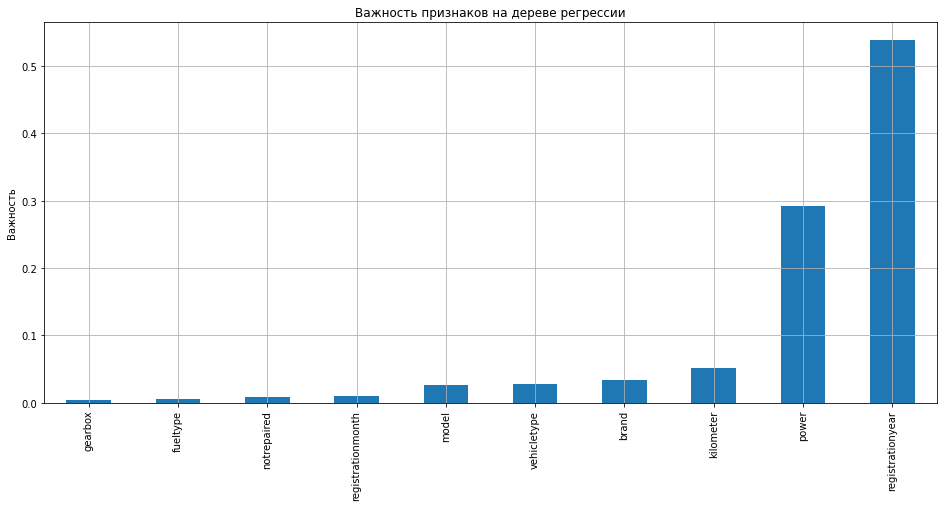

In [33]:
feature_importances_tree = pd.Series(tree_model.feature_importances_, index=X.columns).sort_values()
feature_importances_tree.plot(kind='bar')
plt.title("Важность признаков на дереве регрессии")
plt.ylabel('Важность')
plt.show()

### Catboost

In [34]:
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

cat_model = CatBoostRegressor(random_state=777, verbose=0)

params_cat = {
    'iterations':opt_distr_int(10,300),
    'learning_rate':opt_distr_float(0.01,1.0),
    'depth':opt_distr_int(1,10)
    }

start_time = time.time()

optuna_cat = OptunaSearchCV(
    cat_model, params_cat, n_trials=10,
    random_state=777, scoring='neg_root_mean_squared_error')

optuna_cat.fit(X_train, y_train)

time_tuning_cat = round((time.time() - start_time)/60, 2)
print(f'Время тюнинга модели: {time_tuning_cat} мин \n')

cat_model = optuna_cat.best_estimator_

print(f'Лучшие параметры CatBoostRegressor: {optuna_cat.best_params_}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  from ipykernel import kernelapp as app


Время тюнинга модели: 4.91 мин 

Лучшие параметры CatBoostRegressor: {'iterations': 231, 'learning_rate': 0.49306656486620165, 'depth': 10}


In [35]:
start_time = time.time()

cat_model.fit(X_train, y_train)

time_learn_cat = time.time() - start_time

print(f'Время обучения модели: {time_learn_cat:.4f}s')

Время обучения модели: 16.9886s


In [36]:
start_time = time.time()

predictions_cat = cat_model.predict(X_test)

time_predict_cat = time.time() - start_time

print(f'Время предсказания модели: {time_predict_cat:.4f}s \n')

rmse_cat = mean_squared_error(y_test, predictions_cat, squared=False)
print(f'RMSE модели CatBoostRegressor: {rmse_cat:.3f}')

Время предсказания модели: 0.0926s 

RMSE модели CatBoostRegressor: 1612.718


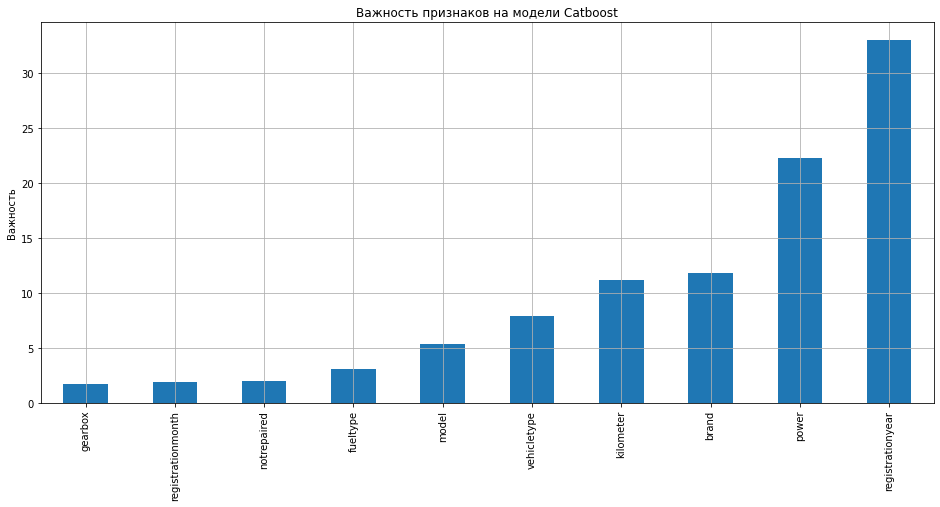

In [37]:
feature_importances_cat = pd.Series(cat_model.feature_importances_, index=X.columns).sort_values()
feature_importances_cat.plot(kind='bar')
plt.title("Важность признаков на модели Catboost")
plt.ylabel('Важность')
plt.show()

### LightGBM

In [38]:
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

lgb_model = LGBMRegressor(random_state=777)

params_lgb = {
    'n_estimators':opt_distr_int(10,300),
    'learning_rate':opt_distr_float(0.01,1.0),
    'max_depth':opt_distr_int(1,10)
    }

start_time = time.time()

optuna_lgb = OptunaSearchCV(
    lgb_model, params_lgb, n_trials=10,
    random_state=777, scoring='neg_root_mean_squared_error')

optuna_lgb.fit(X_train, y_train)

time_tuning_lgb = round((time.time() - start_time)/60, 2)
print(f'Время тюнинга модели: {time_tuning_lgb} мин \n')

lgb_model = optuna_lgb.best_estimator_

print(f'Лучшие параметры LGBMRegressor: {optuna_lgb.best_params_}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  from ipykernel import kernelapp as app


Время тюнинга модели: 1.75 мин 

Лучшие параметры LGBMRegressor: {'n_estimators': 231, 'learning_rate': 0.49306656486620165, 'max_depth': 10}


In [39]:
start_time = time.time()

lgb_model.fit(X_train, y_train)

time_learn_lgb = time.time() - start_time

print(f'Время обучения модели: {time_learn_lgb:.4f}s')

Время обучения модели: 2.7719s


In [40]:
start_time = time.time()

predictions_lgb = lgb_model.predict(X_test)

time_predict_lgb = time.time() - start_time

print(f'Время предсказания модели: {time_predict_lgb:.4f}s \n')

rmse_lgb = mean_squared_error(y_test, predictions_lgb, squared=False)
print(f'RMSE модели LightGBMRegressor: {rmse_lgb:.3f}')

Время предсказания модели: 0.5429s 

RMSE модели LightGBMRegressor: 1620.588


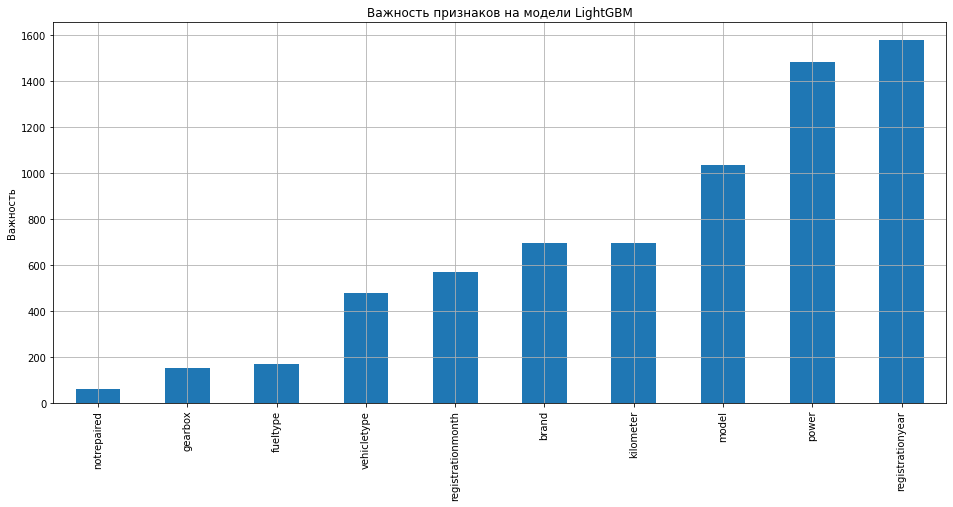

In [41]:
feature_importances_lgb = pd.Series(lgb_model.feature_importances_, index=X.columns).sort_values()
feature_importances_lgb.plot(kind='bar')
plt.title("Важность признаков на модели LightGBM")
plt.ylabel('Важность')
plt.show()

### Проверка на адекватность

In [42]:
for strat in ['mean', 'median', 'constant']:
    if strat == 'constant':
        # Используем моду при стратегии constant
        model = DummyRegressor(strategy=strat, constant=np.argmax(np.bincount(y_test)))
        strat = 'mode'
    else:
        model = DummyRegressor(strategy=strat)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse_dummy= mean_squared_error(y_test, predictions, squared=False)
    print(f'RMSE модели пустышки при использовании стратегии {strat}: {rmse_dummy:.2f}')

RMSE модели пустышки при использовании стратегии mean: 4539.88
RMSE модели пустышки при использовании стратегии median: 4839.62
RMSE модели пустышки при использовании стратегии mode: 6135.17


Модели машинного обучения проходят проверку на адекватность - константные модели показывают намного худшие результаты

## Заключение

In [43]:
# Составим таблицу полученных показателей моделей
chars_tree = [time_learn_tree, time_predict_tree, time_tuning_tree, rmse_tree]
chars_catb = [time_learn_cat, time_predict_cat, time_tuning_cat, rmse_cat]
chars_lgb = [time_learn_lgb, time_predict_lgb, time_tuning_lgb, rmse_lgb]
pd.DataFrame(
    data=[chars_tree, chars_catb, chars_lgb],
    columns=['Время обучения, c','Время предсказания, с', 'Время тюнинга, мин', 'RMSE модели'],
    index=['Дерево регрессии', 'CatBoostRegressor', 'LightGBMRegressor']
)

,"Время обучения, c","Время предсказания, с","Время тюнинга, мин",RMSE модели
Дерево регрессии,1.127459,0.034466,2.19,1811.030856
CatBoostRegressor,16.988576,0.092638,4.91,1612.717792
LightGBMRegressor,2.771905,0.542894,1.75,1620.587917


Лучше всего показали себя модели градиентного бустинга Catboost и LightGBM, их ошибки отличаются весьма незначительно в пользу Catboost, но на имеющемся датасете LightGBM обучается, предсказывает и тюнингуется быстрее в несколько раз

В рамках решения задачи определения стоимости автомобилей я бы рекомендовал к использованию модель LightGBMRegressor, которая даёт быстрые и качественные предсказания при оптимальном времени настройки гиперпараметров.